## Zipcode Project
#### CS 522 - Data Mining
##### Author: Brandon Lasher <br> Email: bl7@hood.edu <br>

Data set link: [https://www.unitedstateszipcodes.org/zip-code-database/](https://www.unitedstateszipcodes.org/zip-code-database/) <br>
Map link and tutorial: [https://github.com/joncutrer/geopandas-tutorial](https://github.com/joncutrer/geopandas-tutorial) <br>
DB SCAN tutorial: [https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/) <br>
DB SCAN example notebook: [https://github.com/gboeing/2014-summer-travels/blob/master/clustering-scikitlearn.ipynb](https://github.com/gboeing/2014-summer-travels/blob/master/clustering-scikitlearn.ipynb)

Steps:
1. Using the dataset of zip codes I pull the latitude, longitude and type information out of the csv.
2. Filter this data to the lower 48 states base on the latitude and longitude data.
3. Plot the initial boundary lines of the lower 48 states to verify this is correct.
4. Import the lat/long data to geopandas, to a format it will understand for plotting
5. Plot both the boundary of the lower 48 states and the zipcode coordinates
6. Use DBScan to determine likely city locations
    - Use Great Circle distance to measure the distance between two points
    - Setup the minimum distance and minimum grouping to be considered a cluster


In [1]:
import pandas as pd #csv handler
import numpy as np  

#Plotting libs
import seaborn as sns
from matplotlib import pyplot as plt
#Display plots inline for Jupyter Notebook
%matplotlib inline

#Map Library
import geopandas as gpd

***
### Reading in the Data
<a id="reading_in_data"></a>

In [2]:
#read Input data
df = pd.read_csv('zip_code_database.csv')
df.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population
0,501,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


In [3]:
# ZIPCODE TYPES: PO Box, Unique, Military, and Standard.
# 
# Bounds of lower 48 via google search
#top = 49.3457868 # north lat
#left = -124.7844079 # west long
#right = -66.9513812 # east long
#bottom =  24.7433195 # south lat
#
df = df[['zip','latitude', 'longitude']][ ( (df['type'] == "STANDARD") | (df['type'] == "PO BOX") ) & ((df['latitude'] < 50) &  (df['latitude'] > 24.7)) & ((df['longitude'] < -66.9) &  (df['longitude'] > -124.6))  ]
df.head()


,zip,latitude,longitude
194,1001,42.06,-72.61
195,1002,42.37,-72.52
196,1003,42.39,-72.52
197,1004,42.37,-72.52
198,1005,42.42,-72.10


In [4]:
#Check the number of NA, just in case
df.isna().sum()

zip          0
latitude     0
longitude    0
dtype: int64

***
### Ploting Initial Data
<a id="plotting_initial_data"></a>

In [5]:
#Read the map data into geopandas
states = gpd.read_file('data/usa-states-census-2014.shp')
states.head()


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


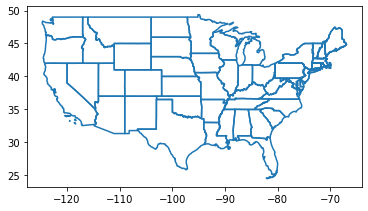

In [6]:
#Plot just the boundary of each state
states.boundary.plot()
plt.show()

In [7]:
#Convert the lat / long data to geopandas
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [8]:
print(gdf.head())

      zip  latitude  longitude                    geometry
194  1001     42.06     -72.61  POINT (-72.61000 42.06000)
195  1002     42.37     -72.52  POINT (-72.52000 42.37000)
196  1003     42.39     -72.52  POINT (-72.52000 42.39000)
197  1004     42.37     -72.52  POINT (-72.52000 42.37000)
198  1005     42.42     -72.10  POINT (-72.10000 42.42000)


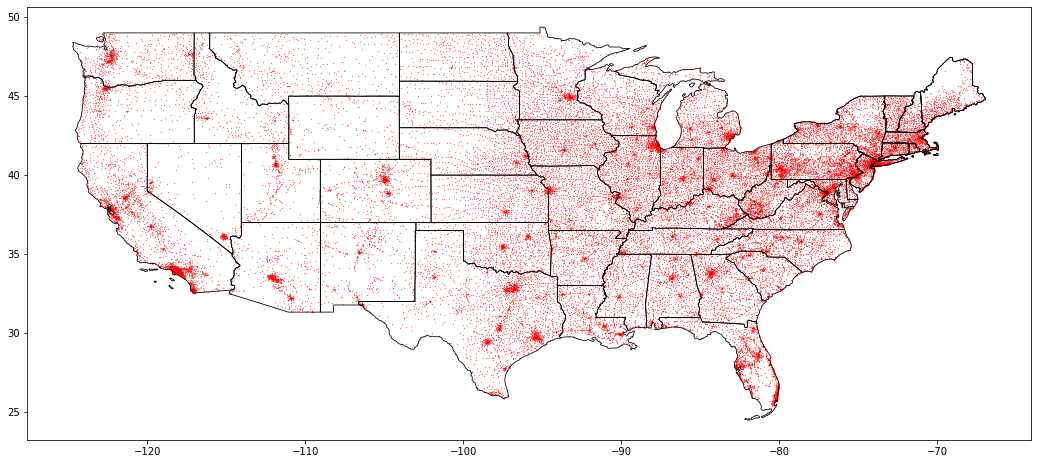

In [9]:
#
#Plot map and data on top one another
#

fig = plt.figure(1, figsize=(18,10)) 
ax = fig.add_subplot()

# Choose the bounding area that matches the lower US for the plot
#  -This is needed if the zipcode lat/long isn't filtered
#ax.set_xlim(-125, -67)
#ax.set_ylim(24, 50)

states.boundary.plot(ax=ax, color='black', linewidth=.8)
gdf.plot(ax=ax, color='red', marker='.', markersize=.2)
plt.show()

***
### Apply DBScan to isolate top cities

In [10]:
#Imports
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from shapely.geometry import MultiPoint
from geopy.distance import great_circle


In [28]:
# Create function wrappers for running this under different scenarios 
#
def runClusters( radius_km, K ):

    #format the data for the DB scan
    X = df[['latitude', 'longitude']].to_numpy()

    #Params Taken from example
    kms_per_radian = 6371.0088 
    #Max distance the points can be seperated to be considered a cluster
    #epsilon = 1.5 / kms_per_radian
    epsilon = radius_km / kms_per_radian

    #min_samples is the minimum cluster size
    #Use ball_tree and haversine to calculate great circle distances
    #   haversine-- great circle distance between 2 points on a sphere
    db = DBSCAN(eps=epsilon, min_samples=K, algorithm='ball_tree', metric='haversine').fit(np.radians(X))
    cluster_labels = db.labels_

    num_clusters = len(set(cluster_labels))

    clusters = pd.Series([X[cluster_labels == n] for n in range(num_clusters-1)])
    print(f'Number of clusters: {num_clusters-1}')

    #Funtion to deteremine center point of the cluster
    # Then determine which point is the closest to that center point
    def get_centermost_point(cluster):
        centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
        centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
        return tuple(centermost_point)

    centermost_points = clusters.map(get_centermost_point)
    return centermost_points

In [12]:
# Function wrapper to plot
#
#
def plotClusters( centermost_points ):
    #Get the centroid points lat/lon and store in data frame
    latitude, longitude = zip(*centermost_points)
    rep_points = pd.DataFrame({'longitude':longitude, 'latitude':latitude})

    #Pull out all the representitive points
    rs = rep_points.apply(lambda row: df[(df['latitude']==row['latitude']) & (df['longitude']==row['longitude'])].iloc[0], axis=1)


    #Plot all the datasets on top to visualize 

    fig, ax = plt.subplots(figsize=[20, 10])
    rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#00FF00', edgecolor='None', alpha=0.9, s=120)
    df_scatter = ax.scatter(df['longitude'], df['latitude'], c='r', alpha=0.2, s=3)
    states.boundary.plot(ax=ax, color='black', linewidth=.8)

    ax.set_title('Full data set vs DBSCAN reduced set')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
    plt.show()

#### Max distance to next closet point .5 km and a K of 2

Observations:
- The max distance between points is too small and that is limiting the number of points which can be considered part of the same cluster. This is made harder due to that the number of points to make a cluster is high.

Number of clusters: 12
0      (40.71, -73.99)
1      (37.27, -79.95)
2      (38.35, -81.63)
3      (38.41, -82.43)
4      (35.19, -80.83)
5       (25.77, -80.2)
6      (41.07, -85.13)
7      (30.06, -89.93)
8      (35.46, -97.51)
9      (32.79, -96.76)
10     (29.76, -95.38)
11    (31.84, -106.43)
dtype: object


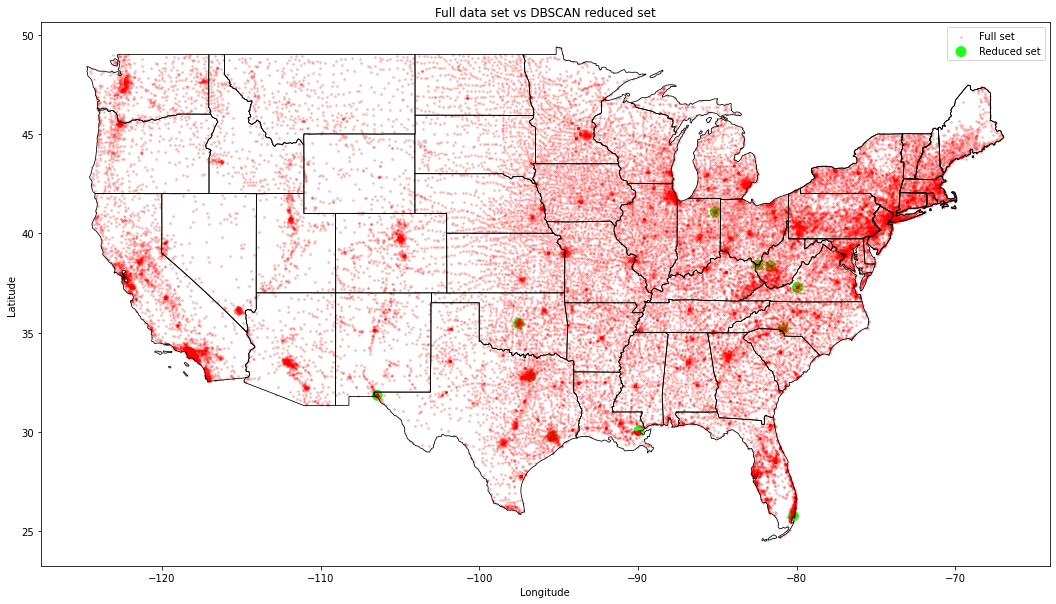

In [29]:
#distance, k 
cluster_center = runClusters(.5, 25)
print( cluster_center )

plotClusters(  cluster_center )

#### Max distance to next closet point 1.5 km and a K of 3
Observations:
- The number of points is too define a cluster is too small. 

Number of clusters: 636
0       (42.17, -72.57)
1       (42.11, -72.53)
2        (42.1, -72.58)
3       (42.45, -73.26)
4       (42.13, -71.96)
             ...       
630    (47.63, -122.34)
631    (47.25, -122.44)
632    (47.21, -122.47)
633    (47.65, -117.42)
634    (47.65, -117.31)
Length: 635, dtype: object


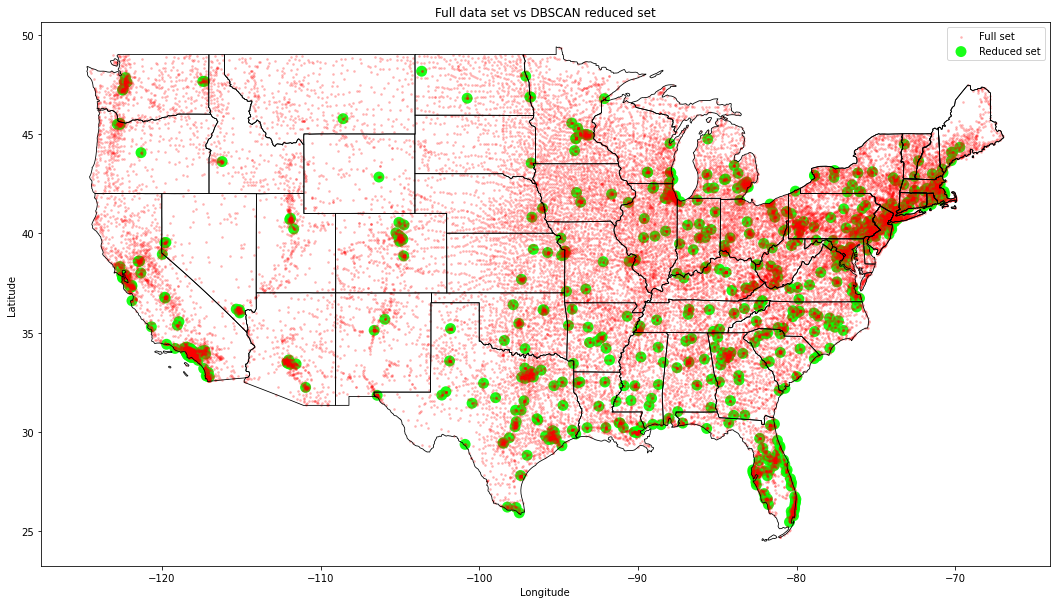

In [17]:
cluster_center = runClusters(1.5, 3)
print( cluster_center )

plotClusters(  cluster_center )

#### Max distance to next closet point 10 km and a K of 20
Observations:
- This is likely the most accurate out of the trial testcases as it gives enough distance and still keeps the k value high. 

Number of clusters: 111
0       (42.11, -72.53)
1       (42.25, -71.81)
2       (42.37, -71.11)
3        (41.8, -71.42)
4       (41.76, -72.68)
             ...       
105    (38.59, -121.41)
106    (37.96, -122.56)
107     (45.5, -122.65)
108     (47.58, -122.3)
109    (47.19, -122.44)
Length: 110, dtype: object


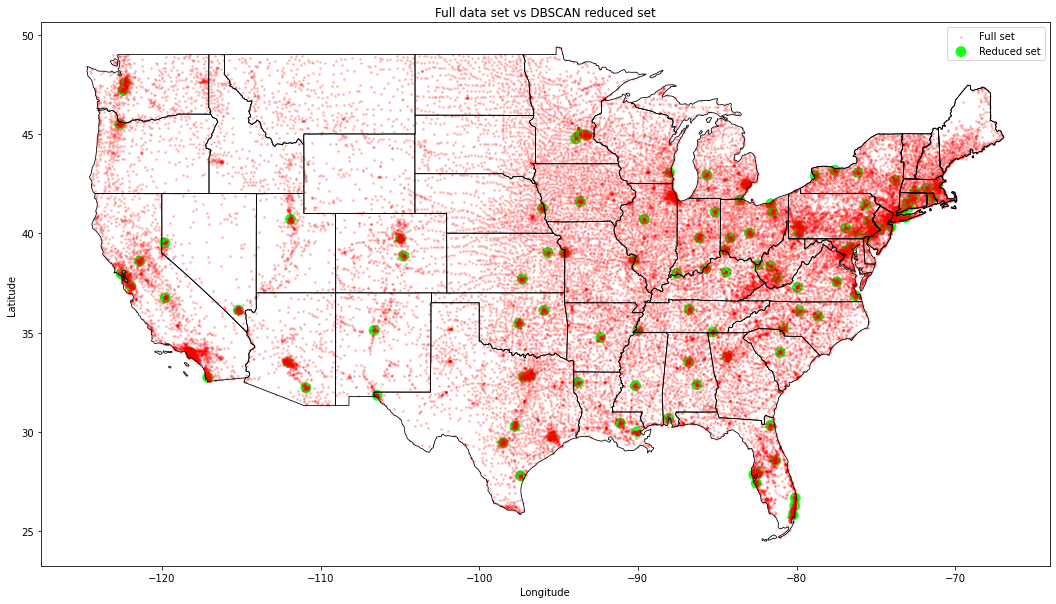

In [23]:
cluster_center = runClusters(10, 20)
print( cluster_center )
plotClusters(  cluster_center )